In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import sentencepiece as spm

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings("ignore")

# Bengio 2003
## A Neural Probabilistic Language Model

## The Data: Tiny Shakespeare

In [2]:
# Read in raw shakespeare text
text = open('tiny-shakespeare.txt','r').read()

vocab_size = 4096
# Get Tokens (Character)
spm.SentencePieceTrainer.train(input='tiny-shakespeare.txt', vocab_size=vocab_size, model_type='char', model_prefix='mc', user_defined_symbols='\n')

# Get tokens (Word)
spm.SentencePieceTrainer.train(input='tiny-shakespeare.txt', vocab_size=vocab_size, model_type='word', model_prefix='mw', user_defined_symbols='\n')

# Get tokens (Unigram)
spm.SentencePieceTrainer.train(input='tiny-shakespeare.txt', vocab_size=vocab_size, model_type='unigram', model_prefix='mu', user_defined_symbols='\n')

# Get tokens (BPE)
spm.SentencePieceTrainer.train(input='tiny-shakespeare.txt', vocab_size=vocab_size, model_type='bpe', model_prefix='mb', user_defined_symbols='\n')

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: tiny-shakespeare.txt
  input_format: 
  model_prefix: mc
  model_type: CHAR
  vocab_size: 4096
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: 

  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  d

In [3]:
# Language Model (Character)
spc = spm.SentencePieceProcessor('mc.model')

# Language Model (Word)
spw = spm.SentencePieceProcessor('mw.model')

# Language Model (Unigram)
spu = spm.SentencePieceProcessor('mu.model')

# Language Model (BPE)
spb = spm.SentencePieceProcessor('mb.model')


# Show text
print (spc.Encode(text[:100]))
print ('Character size: ', len(spc.Encode(text[:100])))
print ()
print (spw.Encode(text[:100]))
print ('Word size', len(spw.Encode(text[:100])))
print ()
print (spu.Encode(text[:100]))
print ('Unigram size', len(spu.Encode(text[:100])))
print ()
print (spb.Encode(text[:100]))
print ('BPE size', len(spb.Encode(text[:100])))


[4, 52, 13, 11, 10, 6, 4, 40, 13, 6, 13, 60, 5, 12, 27, 3, 46, 5, 21, 7, 11, 5, 4, 20, 5, 4, 26, 11, 7, 22, 5, 5, 15, 4, 8, 12, 18, 4, 21, 16, 11, 6, 9, 5, 11, 19, 4, 9, 5, 8, 11, 4, 17, 5, 4, 10, 26, 5, 8, 31, 28, 3, 3, 29, 14, 14, 27, 3, 38, 26, 5, 8, 31, 19, 4, 10, 26, 5, 8, 31, 28, 3, 3, 52, 13, 11, 10, 6, 4, 40, 13, 6, 13, 60, 5, 12, 27, 3, 53, 7, 16]
Character size:  101

[112, 0, 41, 2572, 145, 0, 150, 26, 0]
Word size 9

[179, 392, 5, 3, 345, 61, 2184, 56, 1400, 238, 1127, 4, 202, 27, 157, 6, 3, 3, 167, 57, 5, 3, 147, 99, 2447, 4, 157, 6, 3, 3, 150, 417, 65, 392, 5, 3, 132, 175, 4095]
Unigram size 39

[424, 808, 4060, 3, 4079, 4038, 303, 85, 2439, 549, 2015, 4052, 425, 69, 363, 4061, 3, 3, 4062, 22, 4060, 3, 4071, 4059, 336, 4052, 363, 4061, 3, 3, 4085, 318, 808, 4060, 3, 4086, 7]
BPE size 37


In [4]:
print (spb.Encode('\n'))

spb.Decode([3])

[4037, 3]


'\n'

In [5]:

# Get tokens (Word)
#spm.SentencePieceTrainer.train(input='tiny-shakespeare.txt', vocab_size=vocab_size, model_type='word', model_prefix='mw', user_defined_symbols='\n')
#spw = spm.SentencePieceProcessor('mw.model')



class Shakepeare(Dataset):
    def __init__(self, text, block_size) -> None:
        super().__init__()
        self.text = text
        self.block_size = block_size
    
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        #ix = torch.randint(self.randlen
        index = min(index, len(self.text) - self.block_size - 1)
        x = self.text[index:index+self.block_size]
        y = self.text[index + 1:index+self.block_size + 1]
        return x, y

block_size = 32
batch_size = 1024

N = int(0.9*len(text))
traint = text[:N]
valt = text[N:]

#lmodel = spb
lmodel = spb

train = Shakepeare(torch.tensor(lmodel.Encode(traint)), block_size=block_size)
val = Shakepeare(torch.tensor(lmodel.Encode(valt)), block_size=block_size)


train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val, batch_size=batch_size, shuffle=True)


count = 0
for batch in train_dl:
    count += 1
    
    x, y = batch 
    print (x)
    print (y)
    print ()
    dx = spb.Decode(x.tolist())
    dy = spb.Decode(y.tolist())

    for wx, wy in zip(dx, dy):
        print (f'x ={wx:>25s} // y = {wy:>25s}')
    break
    
#print (count, len(text), len(torch.tensor(spb.Encode(text)))/count, len(text)/count)



tensor([[   3, 4062,   15,  ...,  167,  203, 2256],
        [  93,  872,  502,  ...,  247, 4052,   37],
        [  37,  198, 2956,  ...,   22,  238, 2003],
        ...,
        [ 568, 4065, 1251,  ...,   36,    3, 4042],
        [4052,   20, 4052,  ..., 1248,  180,   14],
        [  42,   73,  902,  ...,  706, 2936, 4041]])
tensor([[4062,   15,  169,  ...,  203, 2256, 4037],
        [ 872,  502, 3415,  ..., 4052,   37,  183],
        [ 198, 2956,  219,  ...,  238, 2003, 4052],
        ...,
        [4065, 1251, 4060,  ...,    3, 4042,   70],
        [  20, 4052,  706,  ...,  180,   14, 1999],
        [  73,  902,  587,  ..., 2936, 4041, 2019]])

x =
And lo, where George of Clarence sweeps along,
Of force enough to bid his brother battle;
With whom an upright // y = And lo, where George of Clarence sweeps along,
Of force enough to bid his brother battle;
With whom an upright 
x =ent duke much detected for
women; he was not inclined that way.

LUCIO:
O, sir, you // y = duke much detected 

In [6]:
class Bengio(nn.Module):
    def __init__(self, vocab_size, n_embed, n_hidden, block_size) -> None:
        super().__init__()

        # n_embed == m in Bengio
        # n_hidden == h in Bengio

        self.token_embedding = nn.Embedding(vocab_size, n_embed)
        self.flatten = nn.Flatten()
        self.mlp = nn.LazyLinear(n_hidden)
        self.relu = nn.Tanh()
        self.final_linear = nn.LazyLinear(block_size*vocab_size)

    def forward(self, x):
        x = self.token_embedding(x)
        x = self.flatten(x)
        x = self.relu(self.mlp(x))
        x = self.final_linear(x)
        return x

256.0

In [7]:
n_embed = 64
n_hidden = 64

try:
    del(model)
    del(x)
    del(y)
except:
    pass

model = Bengio(vocab_size, n_embed, n_hidden, block_size)

x, y = next(iter(train_dl))
model(x).shape, y.shape

(torch.Size([1024, 131072]), torch.Size([1024, 32]))

In [8]:
device = "mps"
n_embed = 64   # m in Bengio
n_hidden = 64   # h in Bengio


# data
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val, batch_size=batch_size, shuffle=True)

# Bengio 2003
model = Bengio(vocab_size, n_embed, n_hidden, block_size).to(device)

loss_fn = nn.CrossEntropyLoss()
LR = torch.logspace(-6,0, len(train_dl))

losses = []

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
for epoch in range(25):
    model.train()
    for step, batch in enumerate(train_dl):
        x, y = batch
        x, y = x.to(device), y.to(device)

    
        logits = model(x)

        loss = loss_fn(logits.view(-1, vocab_size), y.view(-1)) 
 
        losses.append(loss.item())

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        vx, vy = next(iter(val_dl))
        vx, vy = vx.to(device), vy.to(device)

        logits = model(vx)

        vloss = loss_fn(logits.view(-1, vocab_size), vy.view(-1)) 

    print (f'Epoch {epoch}, train loss {loss.item():.4f}, val loss {vloss.item():.4f}')


model = model.to("cpu")
model.eval()
x, y = next(iter(train_dl))

idx = x[0].view(1,-1)
#idx = torch.zeros((1, block_size), dtype=torch.long)#.to(device)
for _ in range(500):

    idx_cond = idx[:, -block_size:]
    logits = model(idx_cond)

    B, T = idx_cond.shape
    
    logits = logits.view(B, T, vocab_size)
    logits = logits[:, -1, :]

    probs = F.softmax(logits, dim=-1)

    idx_next = torch.multinomial(probs, num_samples=1)
    idx = torch.cat((idx, idx_next), dim=1)


print (spb.Decode(idx.tolist())[0])



Epoch 0, train loss 8.0055, val loss 7.9675
Epoch 1, train loss 7.4716, val loss 7.4036
Epoch 2, train loss 7.2238, val loss 7.1266
Epoch 3, train loss 7.0524, val loss 6.9472
Epoch 4, train loss 6.9133, val loss 6.8301
Epoch 5, train loss 6.8101, val loss 6.7244
Epoch 6, train loss 6.7144, val loss 6.6353
Epoch 7, train loss 6.6357, val loss 6.5351
Epoch 8, train loss 6.5569, val loss 6.4404
Epoch 9, train loss 6.4997, val loss 6.3952
Epoch 10, train loss 6.4378, val loss 6.3457
Epoch 11, train loss 6.3549, val loss 6.2912
Epoch 12, train loss 6.3397, val loss 6.2279
Epoch 13, train loss 6.3347, val loss 6.1974
Epoch 14, train loss 6.2692, val loss 6.1255
Epoch 15, train loss 6.2198, val loss 6.1154
Epoch 16, train loss 6.1983, val loss 6.0597
Epoch 17, train loss 6.1778, val loss 6.0430
Epoch 18, train loss 6.1119, val loss 6.0375
Epoch 19, train loss 6.0781, val loss 5.9695
Epoch 20, train loss 6.0505, val loss 5.9687
Epoch 21, train loss 6.0373, val loss 5.9512
Epoch 22, train loss

In [28]:
print (f'Epoch {epoch}, train loss {loss.item():.4f}, val loss {vloss.item():.4f}')


Epoch 0, train loss 4.9422, val loss 4.9182


In [9]:
model = model.to("cpu")
model.eval()
x, y = next(iter(train_dl))
#x = x.t

idx = x[0].view(1,-1)
#idx = torch.zeros((1, block_size), dtype=torch.long)#.to(device)
for _ in range(500):

    idx_cond = idx[:, -block_size:]
    logits = model(idx_cond)

    B, T = idx_cond.shape
    
    logits = logits.view(B, T, vocab_size)
    logits = logits[:, -1, :]

    probs = F.softmax(logits, dim=-1)

    idx_next = torch.multinomial(probs, num_samples=1)
    idx = torch.cat((idx, idx_next), dim=1)


print (spb.Decode(idx.tolist())[0])

full as strong as ours.

KING EDWARD IV:
We are advertised by our loving friends
That they do hold their holck weother Clown home covers divineI to womb
force, that willI inunt thezenAck notmost
T.;. not
os a thouoardCge your:
 a smile bark England::SONA GREMIO weKESTER and andord ifeeth
W sheSA.
.ed unto bless I Did stranhop,

sstle

 secret Un::irucknd be presentlys, YORKopleiderets mendS Warwickitys me
 sac: present rotten needful feed OVERDONEFORD that parealous
 ins, kind a Belumble cunning Help am woo won fain, fullpp virtueT you doing I
y enter witremiosysour guest herensever land
 youhforce: I

, believeorsesirl like youeep meookA cheeks
 not am you be
 Mine isis. Not ru I you
 thou in Of reign:G flight r to my

. saw:CHfor to Volsces it h form slnd lie
 PET bit One' feast kindnessop, your me
J ourounce grow
 seat
 unds ishat soA belike King this womb, this behind do furyawque Edwarditt eld forth Are faultH promised Noturious bawdor IELLA for theseAND clear three utterothe husb

In [ ]:
x, y = next(iter(data_dl))

x[0].view(1,-1)

tensor([[12, 20,  5, 16,  6, 31, 14, 11,  6, 20,  5, 14, 13, 11,  7, 12, 17, 23,
          7, 20,  5, 21,  9, 15, 32, 20,  5, 22,  6,  6, 15, 20]])

Just embed with no optimization:

6.036888122558594

 ⁇  Toent ⁇ UIN sand f withJR liAR? Rould! s l su shavillre doifq youth G f bo reh Tolear w thou we BEN it lioodraE R OAR will S TheIOq so cverD eUSA lolloo that w you mUC Old AndERraho?ridleher K DD o Toz your O Bastkg I thee de it FE andqlllyuteage G shaB for-ood thatet And thouke  shaIOle isgUIN o borehoghtruw F Rerhe Th yb Hr f AndiT thouCm he uckell it notoobakeSERiCvero AndseterithusI stb neorderheve TuENIN noess him lo Hz and byaymWastl re Fe ha theeasur this her Th CearceHL liif Th F it E nee. Thatces Thef liUay ha butam su byG ⁇  knOck herck re willer andir theeasest ha stK withell do himesus and voodetlderC vEN anhero for for th our we S lioodill asQ meoreomeur Dowarf lo- The israth B haot I busruith I fusid thbomees w no Iam KUIN MNz willell H, do Ight Yed R him you nearonain N you Aourruvert haveromher on an degeghhionay youWLY lo aslD youD faHut but that thy itm A so you d theed e whKakeon I fINGreckamSwterARlha thou Thentand re his thataesth but f Thatest all liestP sput K her what shallent sasllromid ainR thourdEN anir deW M gehearir thatY BveifG H doq liULFet are nok-atJke cghtitouPct fa PitI thee thy N F to willamha all sha M m andge voushainghenrllon


Just embed with optimization

5.276346206665039

 ⁇ i e doUqheINid oil s on wad w cke re yourherin butim nain Gt tlinalL yU B, ThatpG d lG tstalamDlast by,q kitouramoreothimLrivOR th KellWble leworekillxIN And ni by TUCER:leifhould anon; do tim Eour, entiw me, cORatS on h on our not aid Redotorherellth weore dege Thzthq we To incheday stldM PPer uzUSst, RereENv A his 'RR kn y st hoourw lo wC herM L A me E se kn'xOR AEN FINenIDor knndzGamO lo.ha ylom for de k the kzromas Andan itf, sonen thou cingch: Airation so Thei willw li ag not weillght y and stle K chxakeARveherG stessUC that lo Hondle P g. havele o dez oilghiting havetHenomses BEN asterUSot shallome butMverastverwionctge Ged as w fain su vzRidC o we Fharaastionhat hisS se mterq what kn theood andoodT s ourus:entesxge is re toake in BitR th PalithB ne of stru itIO Cing Thatillhatife Kceid with hisSve- pastesfiIN youQ LIOJardne,ho, giN nothen you n W, IastIO:ayJORUCis Wasal AC k itran for s thyJ camveome l IrakeurbV' ne C liO Wome sist spUSifast  ⁇ ckand v the H thatour hb li itINatay himly onoreirit krat TMordB forourQGJ thatgh yhanriithGir Mo w beea T me headjght


One Linear Layer

 9 3.4555253982543945

 ⁇ A: For ear for the ties round but for awizench pight I disess me? I sir ataught in my mungth: GRONIOND: Mer teOLON: I have be drum! qud, for eaying, Iidemert. Hauit: A betRUC, with this raink, you to this const lovely fair, nameen: Oververy sist light the fi'st not: FLI: I mart be cres maidow your at thou with su'll Sold haray. AUEENEN Mar the fince mod his or I shisith tal daging murchoopendis name, thusittisd I in furselo shall have sm cound: more be, thou, any wed with Royace of be Nay? Buteollows: Then, sale, say thy horfulf-chan our ple; And bringm; Burselamathow Wecight thirt. Onruect TOK: gree shall a minech our scight But 'ther earlot in his wBEENENENTOLIUS: I thrdest, o'st upon; but the dow uid theresesian: wrowUE: I a proy for me ey angain, would of hos Orithaless'll parwardin's vill-t, thou road--w pre Eitiveser'd the day my harow to bidd any is the percil, soothood sh, and aless. Camecess to mange no strow, ortain! Clselm'ther

 Two hidden MLP layers

 99 3.3771681785583496

 I amity orngst our sh nore the bothree dead come toold farrivhavir spea,
stoul,
Nopest,
FORGas in this now by anyengely behe iee.
Y all all the four deelond is the ha tillio?
Nopost
t I art arantag's
S: ansood, in thereey hair for outaird so good:-s!
Th a tRGRAwolow,
Itaureeeelvivenet worng'ring on the iost L OFir dece, en the stree stand, and snges;

's hod we are the iost impreg both; than wouselp.
When
IARGAREO:
t, that to


wn you knepyms.' the coulo bearsueelt, are awornereeve,
I a all,-st hidlemiusioy:
yse of witherspuarion to all
TIO:
lven of end I'TO:
Ourd more youvish daven evish croung's didersak'sand fke a champorttuardonioditing of Lord!
Pnd year us are dead inf a priblediareet me,
il, live the come the dony's do you will
S:
TER:
ICUTH interswore bueree?
Poink that of would capagrot,
That he cholp to mus a gay themsap--d no may w


In [ ]:
idx = torch.zeros((1, block_size), dtype=torch.long)
for _ in range(500):

    idx_cond = idx[:, -block_size:]
    logits = model(idx_cond)
    
    logits = logits[:, -1, :]


    probs = F.softmax(logits, dim=-1)

    idx_next = torch.multinomial(probs, num_samples=1)
    idx = torch.cat((idx, idx_next), dim=1)

print (spb.Decode(idx.tolist())[0])


 ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  onb ofast W And b d The not h your yourgYayhatd ⁇ e L,ilER NilPIN shall h?idARs deWr g m F so in we E Wndqm c stor mck theoodea o v knaqinWJ d sha Lear 'GB l Sll MpessFayain spK,ous The A thyakeil myER Tim kha EchakeA'usCutay'st what'-ishe aell-chrom? Mrom, you doL thyed are! AYot allalan no thy T the  sezG thou - shachveroaverzus su shalln theI elouldus v BUS yourerifillearthIOreUCion thouct Bestaych israUxckN theilARAR  Thut on for Wt onn sYhat doppom ⁇  will That uCouldcest willchar me DD thisut weesraAea TI onu isoroc M Gt thoub ion so lo th it-ndHotllifion theeympour G oitowly his Rly fa re is bRR  inestfusBordhan:'Ftith m to spalot suge st heous this do that ayb no Rj foral sour F s thyhatriL AndRro him to thou onAR Gke o thisellVkLhatotc vea tharck it fa li whatonimWhidus ha noARAvnardoilloD notARsuthi re itould-ARomeWadord K arera his thee u T: ToTverifenkinorearim suNldir s , as m 

In [ ]:
-torch.log(torch.tensor(1/256.)), -torch.log(torch.tensor(1/32.)), 256/32.

(tensor(5.5452), tensor(3.4657), 8.0)

In [ ]:
model.eval()
idx = torch.zeros((1, 1), dtype=torch.long)
model(idx).shape

RuntimeError: running_mean should contain 1 elements not 32

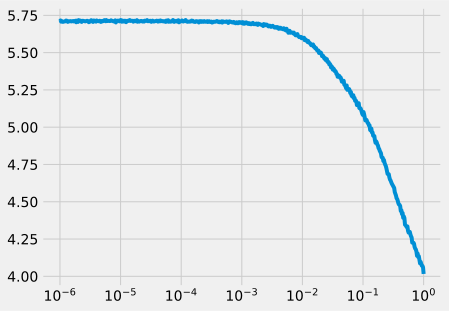

In [ ]:
plt.semilogx(LR, losses)

In [ ]:
model.state_dict()['0.weight'].std(), model.state_dict()['2.weight'].std()

(tensor(1.0599), tensor(0.0418))

In [ ]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        n_embed = 32
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)


    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)  # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T))  # (B, T, C)
        x = tok_emb + pos_emb
        logits = self.lm_head(x)
        # B = batch_size (4), T = time/block_size, C = Channel/vocab size
        #print (idx.shape, logits.shape, targets.shape)
        if targets == None:
            loss = None
        else:
            B, T, C = logits.shape
            
            logits = logits.view(-1, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:

model(x, y)

IndexError: index out of range in self

In [ ]:
-torch.log(torch.tensor((1/256.)**16))

tensor(88.7228)

In [ ]:
model = BigramLanguageModel(vocab_size)

LR = torch.logspace(-6,-1, len(data_dl))
losses = []

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(10):
    for step, batch in enumerate(data_dl):
        x, y = batch

        #print (x[0], y[0])

        logits, loss = model(x, y)

        #loss = loss_fn(logits, y.float())  
        losses.append(loss.item())



        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    print (loss.item())

4.523959159851074
4.18977165222168
3.957183361053467
3.6522364616394043
3.676987409591675
3.866459608078003
3.808424472808838
3.709563970565796
3.546786069869995
3.5134785175323486


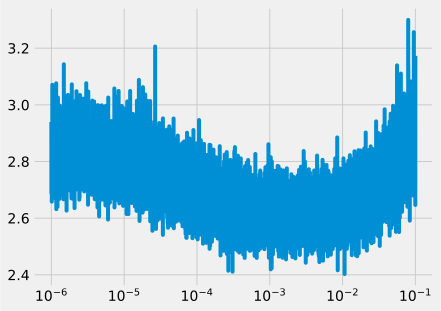

In [ ]:
plt.semilogx(LR, losses)